# <center>2. Down-Sampling </center>

### This example demonstrates performing the following tasks using portpy:

1. Query the existing patients in the database
    (you first need to download the patient database from the link provided in the GitHub page).
2. Query the data provided for a specified patient in the database.
3. Create a simple IMRT plan using CVXPy package. You can call different opensource/commercial optimization engines
    from CVXPy,but you first need to download them and obtain an appropriate license.
    Most commercial optimization engines (e.g., Mosek, Gorubi) give free academic license if you have .edu email
    address
4. Visualise the plan based on down sampled beamlets and voxels (dose_1d distribution, fluence)
5. Evaluate the plan based on down sampled beamlets and voxels

In [1]:
# !pip install portpy-photon

In [2]:
import portpy_photon as pp
pp.__version__

'0.0.3'

In [3]:
# specify the patient data location
# (you first need to download the patient database from the link provided in the GitHub page)
data_dir = r'..\data'
# display the existing patients. To display it in browser rather than console, turn on in_browser=True
pp.Visualize.display_patients(data_dir=data_dir)

F:\Research\Data_newformat\Python-PORT\examples


,patient_id,disease_site,ptv_vol_cc,num_beams,iso_center_shift
0,Lung_Patient_1,Lung,737.229,72,No


In [3]:
# pick a patient from the existing patient list to get detailed info about the patient data (e.g., beams_dict, structures, )
patient_id = 'Lung_Patient_1'
pp.Visualize.display_patient_metadata(patient_id, data_dir=data_dir)

Beams table..


,ID,gantry_angle,collimator_angle,couch_angle,beam_modality,energy_MV,influence_matrix(sparse/full),iso_center,MLC_name,machine_name
0,0,0,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
1,1,5,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
2,2,10,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
3,3,15,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
4,4,20,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
5,5,25,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
6,6,30,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
7,7,35,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
8,8,40,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
9,9,45,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM


Structure table..


,name,volume_cc
0,GTV,356.987
1,PTV,737.229
2,ESOPHAGUS,54.889
3,HEART,1069.187
4,LUNG_L,1969.534
5,LUNG_R,1890.890
6,CORD,63.291
7,SKIN,1.000


### Create plan
Create my_plan object for the planner beams.

For the customized beams_dict, you can pass the argument beam_ids
e.g. my_plan = pp.Plan(patient_name, beam_ids=[0,1,2,3,4,5,6])


In [6]:
my_plan = pp.Plan(patient_id, data_dir=data_dir)

Creating BEV..
Loading sparse influence matrix...
Done


In [7]:
# PortPy can down-sample beamlets as factor of original finest beamlet resolution.
# e.g if the finest beamlet resolution is 2.5mm then down sampled beamlet resolution can be 5, 7.5, 10mm..
# Example create a influence matrix down sampled beamlets of width and height 5mm
beamlet_down_sample_factor = 2
beamlet_width_mm = my_plan.inf_matrix.beamlet_width_mm * beamlet_down_sample_factor
beamlet_height_mm = my_plan.inf_matrix.beamlet_height_mm * beamlet_down_sample_factor
inf_matrix_db = my_plan.create_inf_matrix(beamlet_width_mm=beamlet_width_mm, beamlet_height_mm=beamlet_height_mm)

Creating BEV..
Loading sparse influence matrix...
parsing influence matrix for beam 0
parsing influence matrix for beam 1
parsing influence matrix for beam 2
parsing influence matrix for beam 3
parsing influence matrix for beam 4
parsing influence matrix for beam 5
parsing influence matrix for beam 6
Done


In [8]:
# PortPy can down-sample optimization voxels as factor of ct voxels.
# Example: create another influence matrix for down sampled voxels combining 5 ct voxels in x,y direction and 1 ct voxel in z direction.
# It can be done by passing the argument opt_vox_xyz_res_mm = ct_res_xyz * down_sample_factor
down_sample_factor = [5, 5, 1]
opt_vox_xyz_res_mm = [ct_res * factor for ct_res, factor in zip(my_plan.get_ct_res_xyz_mm(), down_sample_factor)]
inf_matrix_dv = my_plan.create_inf_matrix(opt_vox_xyz_res_mm=opt_vox_xyz_res_mm)
[3 3 1]

Creating BEV..
reindexing voxels...
Loading sparse influence matrix...
creating influence matrix for down sample voxels..
Done


In [9]:
# Now, let us also down sample both voxels and beamlets
inf_matrix_dbv = my_plan.create_inf_matrix(beamlet_width_mm=beamlet_width_mm, beamlet_height_mm=beamlet_height_mm, opt_vox_xyz_res_mm=opt_vox_xyz_res_mm)


Creating BEV..
reindexing voxels...
Loading sparse influence matrix...
parsing influence matrix for beam 0
parsing influence matrix for beam 1
parsing influence matrix for beam 2
parsing influence matrix for beam 3
parsing influence matrix for beam 4
parsing influence matrix for beam 5
parsing influence matrix for beam 6
creating influence matrix for down sample voxels..
Done


### Run Optimization
- Run imrt fluence map optimization using cvxpy and one of the supported solvers and save the optimal solution in sol dictionary
- CVXPy supports several opensource (ECOS, OSQP, SCS) and commercial solvers (e.g., MOSEK, GUROBI, CPLEX)
- For optimization problems with non-linear objective and/or constraints, MOSEK often performs well
- For mixed integer programs, GUROBI/CPLEX are good choices
- If you have .edu email address, you can get free academic license for commercial solvers
- We recommend the commercial solver MOSEK as your solver for the problems in this example,
  however, if you don't have a license, you can try opensource/free solver SCS or ECOS
  see [cvxpy](https://www.cvxpy.org/tutorial/advanced/index.html) for more info about CVXPy solvers
- To set up mosek solver, you can get mosek license file using edu account and place the license file in directory C:\Users\username\mosek

#### Model Formulation

$
   \mbox{Minimize} \quad  w_o||A_{target}\mathbf{x}-pres||_{+} + w_u||A_{target}\mathbf{x}-pres||_{-} + w_{sm}(smoothness \space objective) + w_{oar}  ||A_{oar} \mathbf{x}||
$

$
\mbox{subject to}
$

$
\quad maximum(A_s\mathbf{x}) \leq {d_s}^{max}
$

$
\quad mean(A_s\mathbf{x}) \leq {d_s}^{mean}
$

$
\quad \mathbf{x} \geq 0
$

where $w_o$ (overdose weight) = 10000 , $w_u$ (underdose weight) = 100000, $w_{sm}$ (smoothing weight) = 1000, $w_{oar}$ (oar weight) = 10, $s$ = structure index, $pres$ = prescription dose, $\mathbf{x}$ is beamlet intensity, ${d_s}^{max}$ = maximum dose for structure s, ${d_s}^{mean}$ = mean dose for structure s, $A$ = influence matrix.

Smoothness objective is the total quadratic variation in beamlet intensity in x and y direction. It is given by,

$
smoothness \space objective = w_r\sum_{b\in{B}}\sum_{i\in{I_b}}(\mathbf{x}_i - \mathbf{x}_{R_i})^2 + w_l\sum_{b\in{B}}\sum_{i\in{I_b}}(\mathbf{x}_i - \mathbf{x}_{L_i})^2
$

where $w_r$ = 0.6, $w_l$=0.4, $R_i$ and $L_i$ = right and lower neigbour of beamlet i, $b$ = beam number, $I_b$ = beamlet indices of beam $b$

In [10]:
sol_orig = pp.Optimize.run_IMRT_fluence_map_CVXPy(my_plan, solver='MOSEK')

creating rinds of size [5, 5, 20, 30, 500] mm ..
rinds created!!
Objective Start
Objective done
Constraints Start
Constraints Done
Problem loaded
                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Feb 06 08:16:01 PM: Your problem has 67514 variables, 17 constraints, and 0 parameters.
(CVXPY) Feb 06 08:16:01 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 06 08:16:01 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 06 08:16:01 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 06

(CVXPY) Feb 06 08:18:58 PM: 20  1.0e-05  9.2e-03  1.1e-06  1.00e+00   1.439757561e+02   1.439745564e+02   4.5e-06  75.52 
(CVXPY) Feb 06 08:18:59 PM: 21  6.1e-06  1.3e-02  5.2e-07  9.99e-01   1.031835193e+02   1.031828030e+02   2.7e-06  76.55 
(CVXPY) Feb 06 08:19:01 PM: 22  1.9e-06  2.0e-02  8.8e-08  9.98e-01   6.033238075e+01   6.033216192e+01   8.2e-07  78.66 
(CVXPY) Feb 06 08:19:02 PM: 23  1.5e-06  2.7e-02  6.1e-08  9.95e-01   5.657948658e+01   5.657931487e+01   6.5e-07  79.69 
(CVXPY) Feb 06 08:19:04 PM: 24  5.1e-07  4.5e-02  1.3e-08  9.95e-01   4.756075577e+01   4.756069601e+01   2.3e-07  81.78 
(CVXPY) Feb 06 08:19:05 PM: 25  3.2e-07  6.5e-02  6.3e-09  9.97e-01   4.585461026e+01   4.585457250e+01   1.4e-07  82.83 
(CVXPY) Feb 06 08:19:07 PM: 26  8.0e-08  1.3e-01  7.8e-10  9.97e-01   4.363866235e+01   4.363865310e+01   3.5e-08  84.92 
(CVXPY) Feb 06 08:19:08 PM: 27  2.6e-08  7.2e-01  1.4e-10  9.99e-01   4.316293100e+01   4.316292801e+01   1.1e-08  85.97 
(CVXPY) Feb 06 08:19:10 

In [11]:
# running optimization using downsampled beamlets
sol_db = pp.Optimize.run_IMRT_fluence_map_CVXPy(my_plan, inf_matrix=inf_matrix_db)  # optimize using downsampled beamlets

Objective Start
Objective done
Constraints Start
Constraints Done
Problem loaded
                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Feb 06 08:19:17 PM: Your problem has 64584 variables, 22 constraints, and 0 parameters.
(CVXPY) Feb 06 08:19:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 06 08:19:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 06 08:19:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 06 08:19:17 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Fe

(CVXPY) Feb 06 08:21:11 PM: 23  5.7e-07  2.3e-04  1.2e-08  9.98e-01   5.543635055e+01   5.543631663e+01   2.5e-07  32.78 
(CVXPY) Feb 06 08:21:12 PM: 24  2.6e-07  1.1e-04  3.5e-09  9.98e-01   5.372348676e+01   5.372347142e+01   1.2e-07  33.55 
(CVXPY) Feb 06 08:21:13 PM: 25  3.9e-08  1.6e-05  2.0e-10  9.99e-01   5.254608731e+01   5.254608499e+01   1.7e-08  35.16 
(CVXPY) Feb 06 08:21:15 PM: 26  1.5e-08  8.9e-05  4.8e-11  1.00e+00   5.242426491e+01   5.242426403e+01   6.6e-09  37.23 
(CVXPY) Feb 06 08:21:17 PM: 27  4.3e-09  1.8e-06  7.5e-12  1.00e+00   5.237266468e+01   5.237266442e+01   1.9e-09  38.92 
(CVXPY) Feb 06 08:21:19 PM: 28  4.3e-09  3.6e-06  7.4e-12  1.00e+00   5.237263642e+01   5.237263616e+01   1.9e-09  41.05 
(CVXPY) Feb 06 08:21:21 PM: 29  4.3e-09  1.7e-04  4.2e-12  1.02e+00   5.237263648e+01   5.237263614e+01   1.9e-09  43.47 
(CVXPY) Feb 06 08:21:24 PM: 30  4.3e-09  1.7e-04  4.2e-12  1.04e+00   5.237260731e+01   5.237260698e+01   1.9e-09  45.58 
(CVXPY) Feb 06 08:21:25 

In [12]:
sol_dv = pp.Optimize.run_IMRT_fluence_map_CVXPy(my_plan, inf_matrix=inf_matrix_dv)  # optimize using downsampled voxels

Objective Start
Objective done
Constraints Start
Constraints Done
Problem loaded
                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Feb 06 08:22:11 PM: Your problem has 29222 variables, 27 constraints, and 0 parameters.
(CVXPY) Feb 06 08:22:11 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 06 08:22:11 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 06 08:22:11 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 06 08:22:11 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Fe

(CVXPY) Feb 06 08:23:59 PM: 21  5.1e-09  1.3e-02  2.7e-12  1.00e+00   4.581678328e+01   4.581678297e+01   6.8e-10  48.80 
(CVXPY) Feb 06 08:24:00 PM: 22  1.9e-09  5.2e-02  5.9e-13  1.00e+00   4.581144448e+01   4.581144436e+01   2.5e-10  49.41 
(CVXPY) Feb 06 08:24:01 PM: Optimizer terminated. Time: 49.92   
(CVXPY) Feb 06 08:24:01 PM: 
(CVXPY) Feb 06 08:24:01 PM: 
(CVXPY) Feb 06 08:24:01 PM: Interior-point solution summary
(CVXPY) Feb 06 08:24:01 PM:   Problem status  : PRIMAL_AND_DUAL_FEASIBLE
(CVXPY) Feb 06 08:24:01 PM:   Solution status : OPTIMAL
(CVXPY) Feb 06 08:24:01 PM:   Primal.  obj: 4.5811444475e+01    nrm: 9e+00    Viol.  con: 5e-08    var: 3e-05    cones: 0e+00  
(CVXPY) Feb 06 08:24:01 PM:   Dual.    obj: 4.5811444362e+01    nrm: 1e+05    Viol.  con: 0e+00    var: 1e-08    cones: 0e+00  
-------------------------------------------------------------------------------
                                    Summary                                    
----------------------------

In [13]:
sol_dbv = pp.Optimize.run_IMRT_fluence_map_CVXPy(my_plan, inf_matrix=inf_matrix_dbv)  # optimize using downsampled beamlets and voxels

Objective Start
Objective done
Constraints Start
Constraints Done
Problem loaded
                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Feb 06 08:24:03 PM: Your problem has 26292 variables, 32 constraints, and 0 parameters.
(CVXPY) Feb 06 08:24:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 06 08:24:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 06 08:24:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 06 08:24:03 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Fe

(CVXPY) Feb 06 08:25:07 PM: 23  4.2e-09  2.5e+01  3.5e-12  1.00e+00   5.793607950e+01   5.793607946e+01   7.1e-10  21.88 
(CVXPY) Feb 06 08:25:07 PM: 24  1.3e-09  8.2e+01  6.0e-13  1.00e+00   5.793401147e+01   5.793401145e+01   2.2e-10  22.30 
(CVXPY) Feb 06 08:25:08 PM: Optimizer terminated. Time: 22.75   
(CVXPY) Feb 06 08:25:08 PM: 
(CVXPY) Feb 06 08:25:08 PM: 
(CVXPY) Feb 06 08:25:08 PM: Interior-point solution summary
(CVXPY) Feb 06 08:25:08 PM:   Problem status  : PRIMAL_AND_DUAL_FEASIBLE
(CVXPY) Feb 06 08:25:08 PM:   Solution status : OPTIMAL
(CVXPY) Feb 06 08:25:08 PM:   Primal.  obj: 5.7934011469e+01    nrm: 1e+01    Viol.  con: 2e-08    var: 1e-05    cones: 0e+00  
(CVXPY) Feb 06 08:25:08 PM:   Dual.    obj: 5.7934011455e+01    nrm: 2e+05    Viol.  con: 0e+00    var: 8e-09    cones: 0e+00  
-------------------------------------------------------------------------------
                                    Summary                                    
----------------------------

In [4]:
# # Comment/Uncomment these lines to save & load plan and optimal solutions
# pp.save_plan(my_plan, path=r'C:\temp')
# pp.save_optimal_sol(sol_orig, sol_name='sol_orig', path=r'C:\temp')
# pp.save_optimal_sol(sol_db, sol_name='sol_db', path=r'C:\temp')
# pp.save_optimal_sol(sol_dv, sol_name='sol_dv', path=r'C:\temp')
# pp.save_optimal_sol(sol_dbv, sol_name='sol_dbv', path=r'C:\temp')
my_plan = pp.load_plan('my_plan', path=r'C:\temp')
sol_orig = pp.load_optimal_sol('sol_orig', path=r'C:\temp')
sol_db = pp.load_optimal_sol('sol_db', path=r'C:\temp')
sol_dv = pp.load_optimal_sol('sol_dv', path=r'C:\temp')
sol_dbv = pp.load_optimal_sol('sol_dbv', path=r'C:\temp')

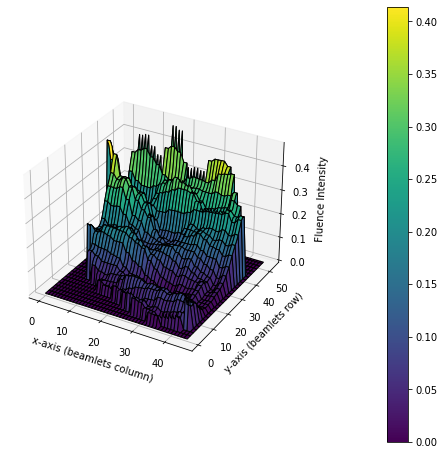

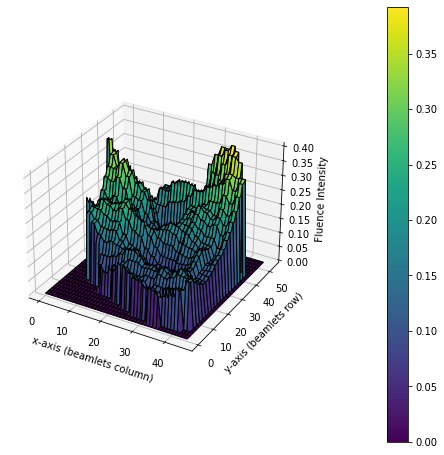

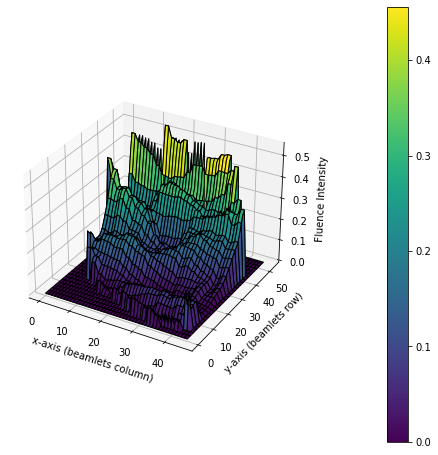

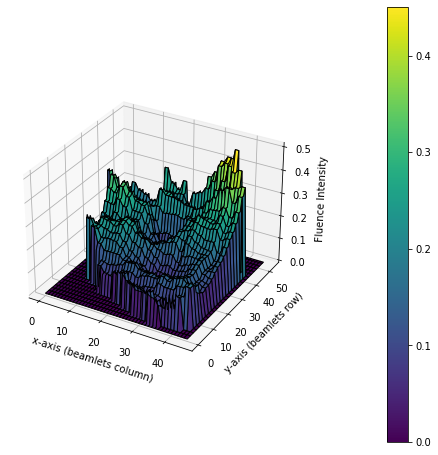

In [5]:
# plot fluence in 3d using the arguments beam id and sol generated using optimization
pp.Visualize.plot_fluence_3d(beam_id=0, sol=sol_orig)
pp.Visualize.plot_fluence_3d(beam_id=0, sol=sol_db)
pp.Visualize.plot_fluence_3d(beam_id=0, sol=sol_dv)
pp.Visualize.plot_fluence_3d(beam_id=0, sol=sol_dbv)


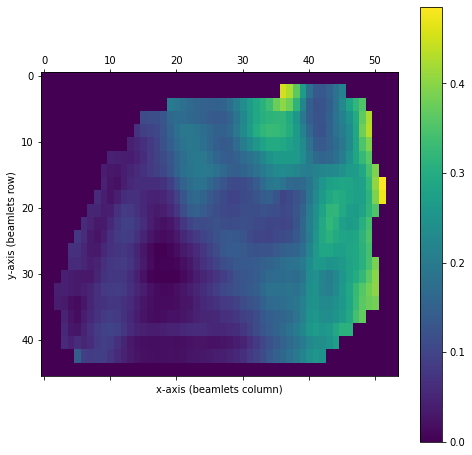

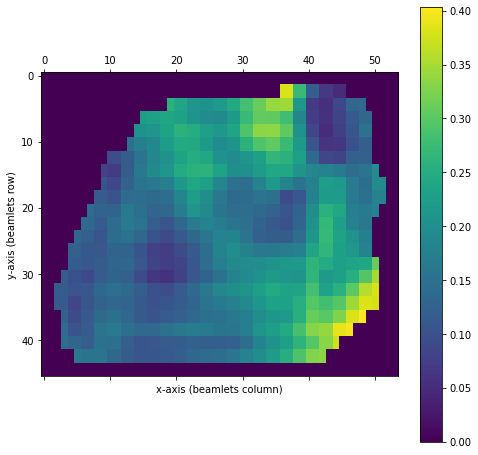

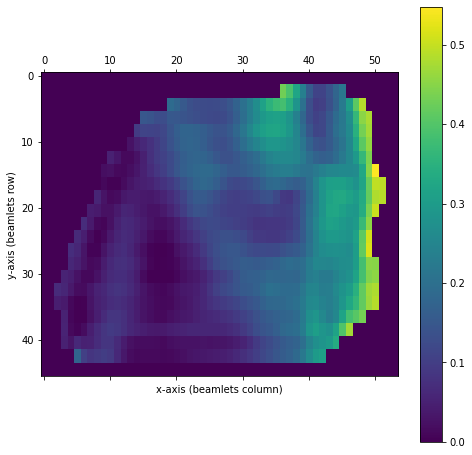

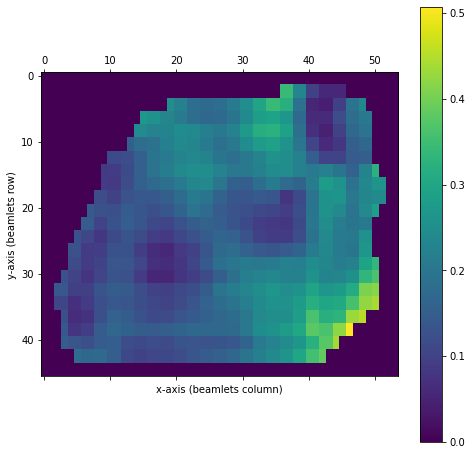

In [6]:
# plot fluence in 2d using the arguments beam id and sol generated using optimization
pp.Visualize.plot_fluence_2d(beam_id=0, sol=sol_orig)
pp.Visualize.plot_fluence_2d(beam_id=0, sol=sol_db)
pp.Visualize.plot_fluence_2d(beam_id=0, sol=sol_dv)
pp.Visualize.plot_fluence_2d(beam_id=0, sol=sol_dbv)


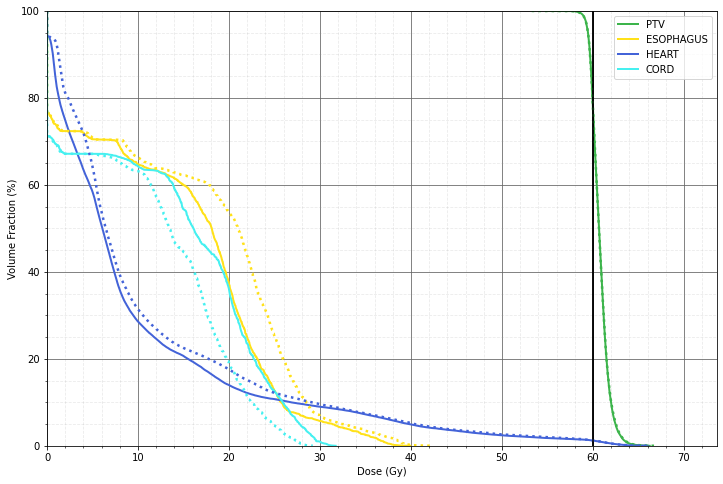

In [5]:
# To know the cost of down sampling beamlets, lets compare the dvh of down sampled beamlets with original
structs = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
sol_db_new = pp.sol_change_inf_matrix(sol_db, inf_matrix=sol_orig['inf_matrix'])
pp.Visualize.plot_dvh(my_plan, sol=sol_orig, structs=structs, style='solid', show=False)
pp.Visualize.plot_dvh(my_plan, sol=sol_db_new, structs=structs, style='dotted', create_fig=False)

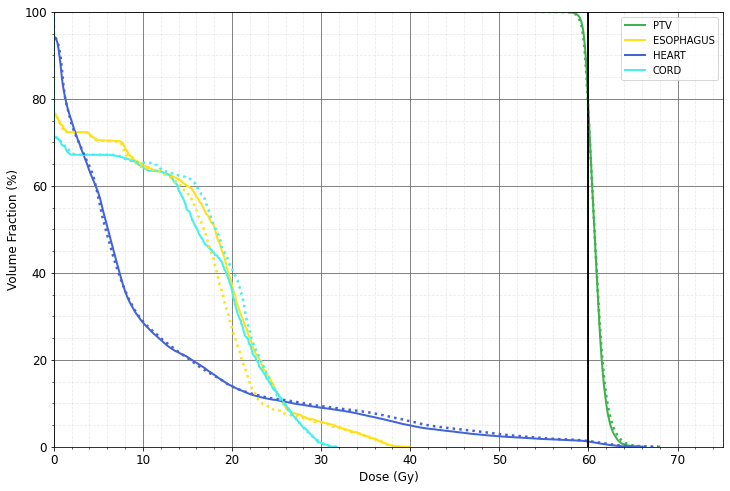

In [6]:
# Similarly to analyze the cost of down sampling voxels, lets compare the dvh of down sampled voxels with original
structs = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
sol_dv_new = pp.sol_change_inf_matrix(sol_dv, inf_matrix=sol_orig['inf_matrix'])
pp.Visualize.plot_dvh(my_plan, sol=sol_orig, structs=structs, style='solid', show=False)
pp.Visualize.plot_dvh(my_plan, sol=sol_dv_new, structs=structs, style='dotted', create_fig=False)

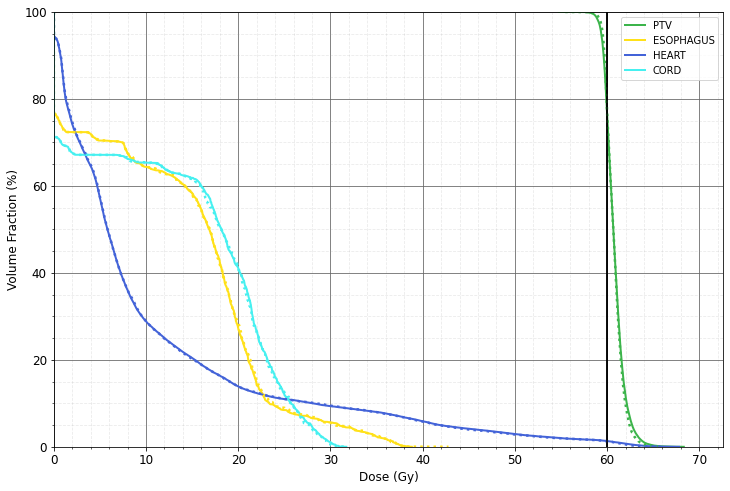

In [7]:
# To get the discrepancy due to down sampling voxels
pp.Visualize.plot_dvh(my_plan, sol=sol_dv_new, structs=structs, style='solid', show=False)
pp.Visualize.plot_dvh(my_plan, sol=sol_dv, structs=structs, style='dotted', create_fig=False)

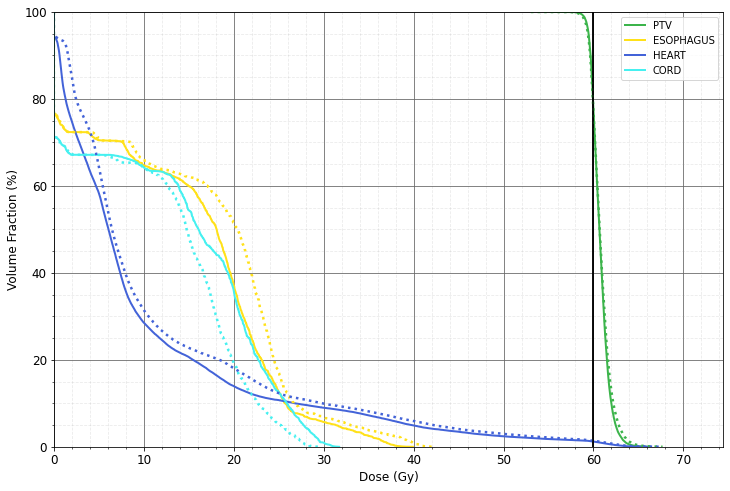

In [8]:
# Now let us plot dvh for analyzing the combined cost of down-sampling beamlets and voxels
structs = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
sol_dbv_new = pp.sol_change_inf_matrix(sol_dbv, inf_matrix=sol_orig['inf_matrix'])
pp.Visualize.plot_dvh(my_plan, sol=sol_orig, structs=structs, style='solid', show=False)
pp.Visualize.plot_dvh(my_plan, sol=sol_dbv_new, structs=structs, style='dotted', create_fig=False)

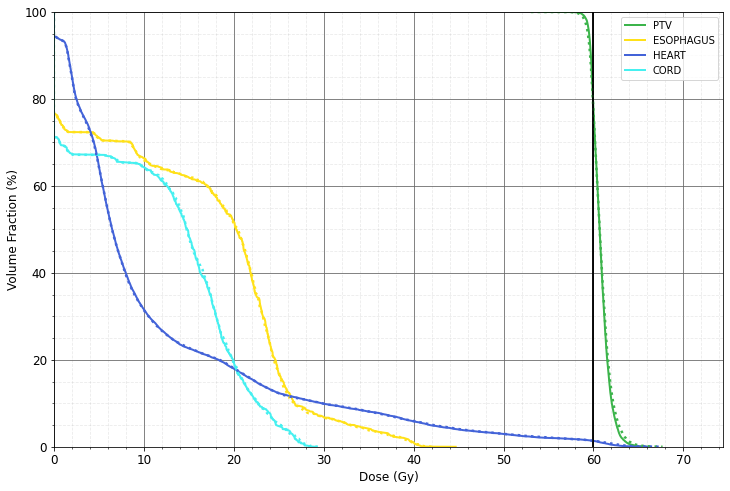

In [9]:
# Similarly let us plot dvh for analyzing the combined discrepancy of down-sampling beamlets and voxels
structs = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
pp.Visualize.plot_dvh(my_plan, sol=sol_dbv, structs=structs, style='solid', show=False)
pp.Visualize.plot_dvh(my_plan, sol=sol_dbv_new, structs=structs, style='dotted', create_fig=False)